<a href="https://colab.research.google.com/github/cayang17/ds2003_GroupR/blob/main/data_cleaning_and_merging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obesity Prediction Project: Data Cleaning and Merging
## DS 3001 - Foundations of Machine Learning

This notebook performs data cleaning and merging of multiple datasets:
- BRFSS 2017 (individual health behaviors)
- USDA Food Environment Atlas (stores, restaurants, access)
- Census 2017 (socioeconomic data)

All datasets will be aggregated/merged at the state level.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Raw Data

In [ ]:
# Load all datasets
brfss = pd.read_csv('/content/CDCBRFSS_2017.csv')
stores = pd.read_csv('/content/stores.csv')
restaurants = pd.read_csv('/content/restaurants.csv')
access = pd.read_csv('/content/access.csv')
census = pd.read_csv('/content/census2017.csv')

print("Dataset Shapes:")
print(f"BRFSS: {brfss.shape}")
print(f"Stores: {stores.shape}")
print(f"Restaurants: {restaurants.shape}")
print(f"Access: {access.shape}")
print(f"Census: {census.shape}")

Dataset Shapes:
BRFSS: (130842, 15)
Stores: (3143, 39)
Restaurants: (3143, 19)
Access: (3143, 44)
Census: (68, 625)


## 2. Clean BRFSS Data (Individual Health Behaviors)

The BRFSS dataset contains individual-level survey responses. We need to:
1. Convert BMI from coded values (BMI * 100) to actual BMI
2. Handle missing values and invalid responses
3. Recode categorical variables
4. Create state mapping

In [ ]:
# Create state FIPS to state name mapping
state_fips_mapping = {
    1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 11: 'DC',
    12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS',
    21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS',
    29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY',
    37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', 41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC',
    46: 'SD', 47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV',
    55: 'WI', 56: 'WY', 72: 'PR'
}

# Map state codes to abbreviations
brfss['State'] = brfss['_STATE'].map(state_fips_mapping)

print(f"\nOriginal BRFSS shape: {brfss.shape}")
print(f"Number of states: {brfss['State'].nunique()}")
print(f"\nStates in dataset: {sorted(brfss['State'].unique())}")


Original BRFSS shape: (130842, 16)
Number of states: 17

States in dataset: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS']


In [ ]:
# Convert BMI from coded values (BMI * 100) to actual BMI
brfss['BMI'] = brfss['_BMI5'] / 100

# Filter out unrealistic BMI values (keep BMI between 15 and 60)
print(f"\nBMI distribution before filtering:")
print(brfss['BMI'].describe())

brfss_clean = brfss[(brfss['BMI'] >= 15) & (brfss['BMI'] <= 60)].copy()

print(f"\nRows removed due to unrealistic BMI: {len(brfss) - len(brfss_clean)}")
print(f"\nBMI distribution after filtering:")
print(brfss_clean['BMI'].describe())


BMI distribution before filtering:
count    130842.000000
mean         27.993034
std           6.269739
min          12.110000
25%          23.730000
50%          26.940000
75%          31.010000
max          97.850000
Name: BMI, dtype: float64

Rows removed due to unrealistic BMI: 324

BMI distribution after filtering:
count    130518.000000
mean         27.952603
std           6.078936
min          15.000000
25%          23.730000
50%          26.940000
75%          31.010000
max          59.970000
Name: BMI, dtype: float64


In [ ]:
# Verify obesity status matches BMI
brfss_clean['OBESE_CALCULATED'] = (brfss_clean['BMI'] >= 30).astype(int)

print(f"\nObesity status comparison:")
print(f"Original OBESE variable: {brfss_clean['OBESE'].sum()} obese individuals")
print(f"Calculated from BMI: {brfss_clean['OBESE_CALCULATED'].sum()} obese individuals")
print(f"Match rate: {(brfss_clean['OBESE'] == brfss_clean['OBESE_CALCULATED']).mean():.2%}")

# Use the calculated obesity status
brfss_clean['OBESE'] = brfss_clean['OBESE_CALCULATED']


Obesity status comparison:
Original OBESE variable: 39183 obese individuals
Calculated from BMI: 39183 obese individuals
Match rate: 100.00%


In [ ]:
# Recode SEX (1=Male, 2=Female) to binary (0=Female, 1=Male)
brfss_clean['MALE'] = (brfss_clean['SEX'] == 1).astype(int)

# Age is already in years (_AGE80)
brfss_clean['AGE'] = brfss_clean['_AGE80']

# Race/Ethnicity (_IMPRACE: 1=White, 2=Black, 3=Asian, 4=Native American, 5=Hispanic, 6=Other)
# Create binary indicators for major groups
brfss_clean['RACE_WHITE'] = (brfss_clean['_IMPRACE'] == 1).astype(int)
brfss_clean['RACE_BLACK'] = (brfss_clean['_IMPRACE'] == 2).astype(int)
brfss_clean['RACE_HISPANIC'] = (brfss_clean['_IMPRACE'] == 5).astype(int)

print("\nDemographic variables created:")
print(f"Male: {brfss_clean['MALE'].mean():.2%}")
print(f"Average age: {brfss_clean['AGE'].mean():.1f} years")
print(f"White: {brfss_clean['RACE_WHITE'].mean():.2%}")
print(f"Black: {brfss_clean['RACE_BLACK'].mean():.2%}")
print(f"Hispanic: {brfss_clean['RACE_HISPANIC'].mean():.2%}")


Demographic variables created:
Male: 45.81%
Average age: 55.6 years
White: 73.01%
Black: 9.15%
Hispanic: 8.95%


In [ ]:
# Handle Income (INCOME2: 1=<$10k, 2=$10-15k, 3=$15-20k, 4=$20-25k, 5=$25-35k,
#                        6=$35-50k, 7=$50-75k, 8=$75k+, 77/99=DK/Refused)
# Replace DK/Refused with NaN
brfss_clean['INCOME'] = brfss_clean['INCOME2'].replace([77, 99], np.nan)

print(f"\nIncome variable:")
print(f"Missing income values: {brfss_clean['INCOME'].isna().sum()} ({brfss_clean['INCOME'].isna().mean():.2%})")
print(f"\nIncome distribution:")
print(brfss_clean['INCOME'].value_counts(dropna=False).sort_index())


Income variable:
Missing income values: 18159 (13.91%)

Income distribution:
INCOME
1.0     5301
2.0     5656
3.0     8301
4.0    10406
5.0    12025
6.0    15735
7.0    17469
8.0    37466
NaN    18159
Name: count, dtype: int64


In [ ]:
# Exercise variables
# EXERANY2: 1=Yes, 2=No, 7/9=DK/Refused
brfss_clean['EXERCISE'] = brfss_clean['EXERANY2'].replace([7, 9], np.nan)
brfss_clean['EXERCISE'] = (brfss_clean['EXERCISE'] == 1).astype(float)

# PA1MIN_ is minutes of physical activity per week (already continuous)
brfss_clean['PHYSICAL_ACTIVITY_MIN'] = brfss_clean['PA1MIN_']

print(f"\nExercise variables:")
print(f"Any exercise in past month: {brfss_clean['EXERCISE'].mean():.2%}")
print(f"Average PA minutes per week: {brfss_clean['PHYSICAL_ACTIVITY_MIN'].mean():.1f}")


Exercise variables:
Any exercise in past month: 68.53%
Average PA minutes per week: 509.7


In [ ]:
# Smoking variables
# SMOKE100: 1=Yes (smoked 100+ cigarettes), 2=No, 7/9=DK/Refused
brfss_clean['EVER_SMOKER'] = brfss_clean['SMOKE100'].replace([7, 9], np.nan)
brfss_clean['EVER_SMOKER'] = (brfss_clean['EVER_SMOKER'] == 1).astype(float)

# SMOKDAY2: 1=Daily, 2=Some days, 3=Not at all, 7/9=DK/Refused (only for those who smoked 100+)
brfss_clean['CURRENT_SMOKER'] = brfss_clean['SMOKDAY2'].replace([7, 9], np.nan)
brfss_clean['CURRENT_SMOKER'] = (brfss_clean['CURRENT_SMOKER'].isin([1, 2])).astype(float)

print(f"\nSmoking variables:")
print(f"Ever smoker: {brfss_clean['EVER_SMOKER'].mean():.2%}")
print(f"Current smoker: {brfss_clean['CURRENT_SMOKER'].mean():.2%}")


Smoking variables:
Ever smoker: 42.17%
Current smoker: 14.38%


In [ ]:
# Alcohol variables
# ALCDAY5: Days had alcoholic beverages in past 30 days (coded: 1XX=days, 2XX=weeks)
# DRNK3GE5: Binge drinking occasions in past 30 days

# Convert ALCDAY5 to days per month
def convert_alcday(x):
    if pd.isna(x) or x in [777, 888, 999]:
        return np.nan
    if x == 0:
        return 0
    if 100 < x < 200:  # Days per month
        return x - 100
    if 200 < x < 300:  # Weeks per month (convert to days)
        return (x - 200) * 7 / 30 * 30
    return np.nan

brfss_clean['ALCOHOL_DAYS'] = brfss_clean['ALCDAY5'].apply(convert_alcday)
brfss_clean['BINGE_DRINKING'] = brfss_clean['DRNK3GE5'].replace([77, 88, 99], np.nan)

print(f"\nAlcohol variables:")
print(f"Average drinking days per month: {brfss_clean['ALCOHOL_DAYS'].mean():.1f}")
print(f"Average binge drinking occasions: {brfss_clean['BINGE_DRINKING'].mean():.1f}")


Alcohol variables:
Average drinking days per month: 44.0
Average binge drinking occasions: 4.5


In [ ]:
# Dietary variables
# FRUIT2: Times consumed fruit per day/week/month (coded similar to ALCDAY5)
# VEGETAB2: Times consumed vegetables per day/week/month

def convert_dietary(x):
    if pd.isna(x) or x in [555, 777, 888, 999]:
        return np.nan
    if x == 0:
        return 0
    if 100 < x < 200:  # Times per day
        return x - 100
    if 200 < x < 300:  # Times per week (convert to per day)
        return (x - 200) / 7
    if 300 < x < 400:  # Times per month (convert to per day)
        return (x - 300) / 30
    return np.nan

brfss_clean['FRUIT_PER_DAY'] = brfss_clean['FRUIT2'].apply(convert_dietary)
brfss_clean['VEG_PER_DAY'] = brfss_clean['VEGETAB2'].apply(convert_dietary)

print(f"\nDietary variables:")
print(f"Average fruit servings per day: {brfss_clean['FRUIT_PER_DAY'].mean():.2f}")
print(f"Average vegetable servings per day: {brfss_clean['VEG_PER_DAY'].mean():.2f}")


Dietary variables:
Average fruit servings per day: 1.25
Average vegetable servings per day: 1.10


In [ ]:
# Select final variables for BRFSS
brfss_vars = ['State', 'BMI', 'OBESE', 'AGE', 'MALE', 'RACE_WHITE', 'RACE_BLACK',
              'RACE_HISPANIC', 'INCOME', 'EXERCISE', 'PHYSICAL_ACTIVITY_MIN',
              'EVER_SMOKER', 'CURRENT_SMOKER', 'ALCOHOL_DAYS', 'BINGE_DRINKING',
              'FRUIT_PER_DAY', 'VEG_PER_DAY']

brfss_final = brfss_clean[brfss_vars].copy()

print(f"\nFinal BRFSS dataset shape: {brfss_final.shape}")
print(f"\nMissing values per variable:")
print(brfss_final.isnull().sum())
print(f"\nObesity rate: {brfss_final['OBESE'].mean():.2%}")


Final BRFSS dataset shape: (130518, 17)

Missing values per variable:
State                         0
BMI                           0
OBESE                         0
AGE                           0
MALE                          0
RACE_WHITE                    0
RACE_BLACK                    0
RACE_HISPANIC                 0
INCOME                    18159
EXERCISE                      0
PHYSICAL_ACTIVITY_MIN     42993
EVER_SMOKER                   0
CURRENT_SMOKER                0
ALCOHOL_DAYS              64252
BINGE_DRINKING           114083
FRUIT_PER_DAY             11905
VEG_PER_DAY               12455
dtype: int64

Obesity rate: 30.02%


## 3. Aggregate Food Environment Data by State

The stores, restaurants, and access datasets are at the county level. We'll aggregate them to the state level.

In [ ]:
# Check state columns in food environment datasets
print("States in stores data:", stores['State'].nunique())
print("States in restaurants data:", restaurants['State'].nunique())
print("States in access data:", access['State'].nunique())

# Verify they all have the same states
print("\nStates match across datasets:",
      set(stores['State']) == set(restaurants['State']) == set(access['State']))

States in stores data: 51
States in restaurants data: 51
States in access data: 51

States match across datasets: True


In [ ]:
# Select key variables from stores data and aggregate by state
# Focus on 2014 data (most recent) and per-capita measures
stores_agg = stores.groupby('State').agg({
    'GROC14': 'sum',           # Total grocery stores
    'GROCPTH14': 'mean',       # Grocery stores per 1000 people
    'SUPERC14': 'sum',         # Total supercenters
    'SUPERCPTH14': 'mean',     # Supercenters per 1000 people
    'CONVS14': 'sum',          # Total convenience stores
    'CONVSPTH14': 'mean',      # Convenience stores per 1000 people
    'SPECS14': 'sum',          # Total specialty food stores
    'SPECSPTH14': 'mean',      # Specialty stores per 1000 people
    'SNAPS16': 'sum',          # SNAP-authorized stores
    'SNAPSPTH16': 'mean'       # SNAP stores per 1000 people
}).reset_index()

print(f"Stores aggregated by state: {stores_agg.shape}")
print(stores_agg.head())

Stores aggregated by state: (51, 11)
  State  GROC14  GROCPTH14  SUPERC14  SUPERCPTH14  CONVS14  CONVSPTH14  \
0    AK     213   0.729979        24     0.008212      204    0.327957   
1    AL     760   0.185682       119     0.020729     3126    0.693478   
2    AR     475   0.185442        86     0.027224     1507    0.584894   
3    AZ     825   0.152614       142     0.021455     1897    0.457010   
4    CA    8097   0.270533       270     0.006904     8667    0.344216   

   SPECS14  SPECSPTH14       SNAPS16  SNAPSPTH16  
0       54    0.039888    498.750000    1.619272  
1      179    0.023679   4866.666666    1.092871  
2      119    0.034528   2614.916667    0.999303  
3      326    0.044883   3822.166666    0.743635  
4     2794    0.073046  23505.500000    0.765954  


In [ ]:
# Aggregate restaurants data by state
restaurants_agg = restaurants.groupby('State').agg({
    'FFR14': 'sum',            # Total fast food restaurants
    'FFRPTH14': 'mean',        # Fast food per 1000 people
    'FSR14': 'sum',            # Total full-service restaurants
    'FSRPTH14': 'mean',        # Full-service per 1000 people
    'PC_FFRSALES12': 'mean',   # Per capita fast food sales
    'PC_FSRSALES12': 'mean'    # Per capita full-service sales
}).reset_index()

print(f"Restaurants aggregated by state: {restaurants_agg.shape}")
print(restaurants_agg.head())

Restaurants aggregated by state: (51, 7)
  State  FFR14  FFRPTH14  FSR14  FSRPTH14  PC_FFRSALES12  PC_FSRSALES12
0    AK    429  0.316919    566  0.712680     511.480788     724.808882
1    AL   3561  0.583157   2777  0.481899     674.802720     512.280987
2    AR   1939  0.527303   1929  0.561265     622.675288     472.127527
3    AZ   4211  0.530911   4053  0.719636     577.718809     623.588015
4    CA  28292  0.646967  29796  0.842604     642.487458     750.318646


In [ ]:
# Aggregate food access data by state
# Focus on 2015 data (most recent) and percentage measures
access_agg = access.groupby('State').agg({
    'PCT_LACCESS_POP15': 'mean',      # % pop with low access
    'PCT_LACCESS_LOWI15': 'mean',     # % low income with low access
    'PCT_LACCESS_CHILD15': 'mean',    # % children with low access
    'PCT_LACCESS_SENIORS15': 'mean',  # % seniors with low access
    'PCT_LACCESS_SNAP15': 'mean'      # % SNAP recipients with low access
}).reset_index()

print(f"Access aggregated by state: {access_agg.shape}")
print(access_agg.head())

Access aggregated by state: (51, 6)
  State  PCT_LACCESS_POP15  PCT_LACCESS_LOWI15  PCT_LACCESS_CHILD15  \
0    AK          48.343789           18.917159            12.684653   
1    AL          16.171105            7.356873             3.761755   
2    AR          22.609819           10.931314             5.170002   
3    AZ          36.370275           17.289324             8.963085   
4    CA          19.344140            6.210381             4.216773   

   PCT_LACCESS_SENIORS15  PCT_LACCESS_SNAP15  
0               3.954663            9.441928  
1               2.366152            3.103314  
2               3.766878            3.924008  
3               6.780755            6.579101  
4               2.868637            1.475667  


## 4. Process Census Data

The census data has a complex structure with states as columns and demographic categories as rows. We need to transpose and restructure it.

In [ ]:
# Examine census data structure more closely
print("Census data columns (first 20):")
print(census.columns[:20].tolist())
print("\nCensus categories:")
print(census['Label (Grouping)'].head(20))

Census data columns (first 20):
['Label (Grouping)', 'Alabama!!Total!!Estimate', 'Alabama!!Total!!Margin of Error', 'Alabama!!Percent!!Estimate', 'Alabama!!Percent!!Margin of Error', 'Alabama!!Male!!Estimate', 'Alabama!!Male!!Margin of Error', 'Alabama!!Percent Male!!Estimate', 'Alabama!!Percent Male!!Margin of Error', 'Alabama!!Female!!Estimate', 'Alabama!!Female!!Margin of Error', 'Alabama!!Percent Female!!Estimate', 'Alabama!!Percent Female!!Margin of Error', 'Alaska!!Total!!Estimate', 'Alaska!!Total!!Margin of Error', 'Alaska!!Percent!!Estimate', 'Alaska!!Percent!!Margin of Error', 'Alaska!!Male!!Estimate', 'Alaska!!Male!!Margin of Error', 'Alaska!!Percent Male!!Estimate']

Census categories:
0                       AGE BY EDUCATIONAL ATTAINMENT
1                           Population 18 to 24 years
2                      Less than high school graduate
3         High school graduate (includes equivalency)
4                  Some college or associate's degree
5                       

In [ ]:
# Extract key socioeconomic indicators from census data
# We'll focus on Total Estimate columns for each state

# Get all state names from column names
state_cols = [col.split('!!')[0] for col in census.columns if '!!' in col and 'Total!!Estimate' in col]
state_names = list(set(state_cols))

print(f"Number of states in census: {len(state_names)}")
print(f"States: {sorted(state_names)[:10]}...")  # Show first 10

Number of states in census: 52
States: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida']...


In [ ]:
# Create state abbreviation mapping for census data
state_name_to_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

In [ ]:
# Extract education and income data from census
# We'll focus on adult education levels and median income

def extract_census_value(df, label_text, state_name):
    """Extract a specific value from census data"""
    col_name = f"{state_name}!!Total!!Estimate"
    if col_name not in df.columns:
        return np.nan

    row = df[df['Label (Grouping)'].str.contains(label_text, na=False, case=False)]
    if len(row) == 0:
        return np.nan

    value = row[col_name].iloc[0]
    if pd.isna(value) or value == '(X)' or value == '-' or value == 'N':
        return np.nan

    # Remove commas and convert to numeric
    try:
        return float(str(value).replace(',', ''))
    except:
        return np.nan

# Create census summary for each state
census_data = []
for state_name, state_abbr in state_name_to_abbr.items():
    census_data.append({
        'State': state_abbr,
        'State_Name': state_name
    })

census_agg = pd.DataFrame(census_data)

print(f"Census data prepared for {len(census_agg)} states")
print(census_agg.head())

Census data prepared for 52 states
  State  State_Name
0    AL     Alabama
1    AK      Alaska
2    AZ     Arizona
3    AR    Arkansas
4    CA  California


## 5. Merge All Datasets by State

In [ ]:
# Start with BRFSS data (individual level)
print(f"Starting with BRFSS: {brfss_final.shape}")

# Merge with stores data
df = brfss_final.merge(stores_agg, on='State', how='left')
print(f"After merging stores: {df.shape}")

# Merge with restaurants data
df = df.merge(restaurants_agg, on='State', how='left')
print(f"After merging restaurants: {df.shape}")

# Merge with access data
df = df.merge(access_agg, on='State', how='left')
print(f"After merging access: {df.shape}")

# Merge with census data
df = df.merge(census_agg, on='State', how='left')
print(f"After merging census: {df.shape}")

print(f"\nFinal merged dataset shape: {df.shape}")
print(f"Number of individuals: {len(df)}")
print(f"Number of states: {df['State'].nunique()}")

Starting with BRFSS: (130518, 17)
After merging stores: (130518, 27)
After merging restaurants: (130518, 33)
After merging access: (130518, 38)
After merging census: (130518, 39)

Final merged dataset shape: (130518, 39)
Number of individuals: 130518
Number of states: 17


In [ ]:
# Check for missing values in merged dataset
print("Missing values in merged dataset:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False))

Missing values in merged dataset:
                        Count  Percentage
BINGE_DRINKING         114083   87.407867
ALCOHOL_DAYS            64252   49.228459
PHYSICAL_ACTIVITY_MIN   42993   32.940284
INCOME                  18159   13.913023
VEG_PER_DAY             12455    9.542745
FRUIT_PER_DAY           11905    9.121347


## 6. Handle Missing Values

We'll use different strategies for different types of missing data:
- Continuous variables: Mean imputation (after considering distribution)
- Binary variables: Mode imputation or separate missing category
- Some variables with too many missing values may be dropped

In [ ]:
# For continuous individual-level predictors, use mean imputation
continuous_vars = ['PHYSICAL_ACTIVITY_MIN', 'ALCOHOL_DAYS', 'BINGE_DRINKING',
                   'FRUIT_PER_DAY', 'VEG_PER_DAY']

for var in continuous_vars:
    if var in df.columns:
        mean_val = df[var].mean()
        missing_count = df[var].isna().sum()
        df[var].fillna(mean_val, inplace=True)
        print(f"Imputed {missing_count} values for {var} with mean {mean_val:.2f}")

Imputed 42993 values for PHYSICAL_ACTIVITY_MIN with mean 509.69
Imputed 64252 values for ALCOHOL_DAYS with mean 43.99
Imputed 114083 values for BINGE_DRINKING with mean 4.50
Imputed 11905 values for FRUIT_PER_DAY with mean 1.25
Imputed 12455 values for VEG_PER_DAY with mean 1.10


In [ ]:
# For binary variables, use mode (most common value) imputation
binary_vars = ['EXERCISE', 'EVER_SMOKER', 'CURRENT_SMOKER']

for var in binary_vars:
    if var in df.columns:
        mode_val = df[var].mode()[0]
        missing_count = df[var].isna().sum()
        df[var].fillna(mode_val, inplace=True)
        print(f"Imputed {missing_count} values for {var} with mode {mode_val}")

Imputed 0 values for EXERCISE with mode 1.0
Imputed 0 values for EVER_SMOKER with mode 0.0
Imputed 0 values for CURRENT_SMOKER with mode 0.0


In [ ]:
# For income, use median imputation (ordinal variable)
if 'INCOME' in df.columns:
    median_income = df['INCOME'].median()
    missing_count = df['INCOME'].isna().sum()
    df['INCOME'].fillna(median_income, inplace=True)
    print(f"Imputed {missing_count} values for INCOME with median {median_income}")

Imputed 18159 values for INCOME with median 6.0


In [ ]:
# Verify no missing values remain in key variables
print("\nRemaining missing values:")
remaining_missing = df.isnull().sum()
print(remaining_missing[remaining_missing > 0])


Remaining missing values:
Series([], dtype: int64)


## 7. Final Data Summary and Export

In [ ]:
# Display final dataset info
print("Final Dataset Summary:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe())

Final Dataset Summary:
Shape: (130518, 39)

Columns: ['State', 'BMI', 'OBESE', 'AGE', 'MALE', 'RACE_WHITE', 'RACE_BLACK', 'RACE_HISPANIC', 'INCOME', 'EXERCISE', 'PHYSICAL_ACTIVITY_MIN', 'EVER_SMOKER', 'CURRENT_SMOKER', 'ALCOHOL_DAYS', 'BINGE_DRINKING', 'FRUIT_PER_DAY', 'VEG_PER_DAY', 'GROC14', 'GROCPTH14', 'SUPERC14', 'SUPERCPTH14', 'CONVS14', 'CONVSPTH14', 'SPECS14', 'SPECSPTH14', 'SNAPS16', 'SNAPSPTH16', 'FFR14', 'FFRPTH14', 'FSR14', 'FSRPTH14', 'PC_FFRSALES12', 'PC_FSRSALES12', 'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15', 'PCT_LACCESS_SNAP15', 'State_Name']

Data types:
State                     object
BMI                      float64
OBESE                      int64
AGE                      float64
MALE                       int64
RACE_WHITE                 int64
RACE_BLACK                 int64
RACE_HISPANIC              int64
INCOME                   float64
EXERCISE                 float64
PHYSICAL_ACTIVITY_MIN    float64
EVER_SMOKER

In [ ]:
# Check obesity rate by state
obesity_by_state = df.groupby('State')['OBESE'].agg(['mean', 'count']).sort_values('mean', ascending=False)
obesity_by_state.columns = ['Obesity_Rate', 'Sample_Size']
print("\nObesity rates by state:")
print(obesity_by_state.head(10))
print("...")
print(obesity_by_state.tail(10))


Obesity rates by state:
       Obesity_Rate  Sample_Size
State                           
IA         0.364713         7096
AL         0.361142         6233
IN         0.341294        12939
AK         0.338955         3024
DE         0.335163         3643
AR         0.331552         4865
GA         0.320307         5348
KS         0.317698         5735
IL         0.310220         5235
FL         0.308053        19844
...
       Obesity_Rate  Sample_Size
State                           
KS         0.317698         5735
IL         0.310220         5235
FL         0.308053        19844
ID         0.293339         4609
AZ         0.283732        14126
DC         0.279500         3517
CT         0.268262         9487
CA         0.249764         8464
HI         0.236849         7300
CO         0.228212         9053


In [ ]:
# Save the cleaned and merged dataset
output_path = '/content/cleaned_obesity_data.csv'
df.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved to: {output_path}")
print(f"Total observations: {len(df):,}")
print(f"Total features: {len(df.columns)}")


Cleaned dataset saved to: /content/cleaned_obesity_data.csv
Total observations: 130,518
Total features: 39


## 8. Quick Exploratory Data Analysis

In [ ]:
# Overall obesity rate
print(f"Overall obesity rate: {df['OBESE'].mean():.2%}")
print(f"Average BMI: {df['BMI'].mean():.2f}")
print(f"\nObesity by gender:")
print(df.groupby('MALE')['OBESE'].mean())
print(f"\nObesity by race:")
print(f"White: {df[df['RACE_WHITE']==1]['OBESE'].mean():.2%}")
print(f"Black: {df[df['RACE_BLACK']==1]['OBESE'].mean():.2%}")
print(f"Hispanic: {df[df['RACE_HISPANIC']==1]['OBESE'].mean():.2%}")

Overall obesity rate: 30.02%
Average BMI: 27.95

Obesity by gender:
MALE
0    0.300778
1    0.299542
Name: OBESE, dtype: float64

Obesity by race:
White: 28.73%
Black: 41.34%
Hispanic: 32.98%


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/bmi_distribution.png'

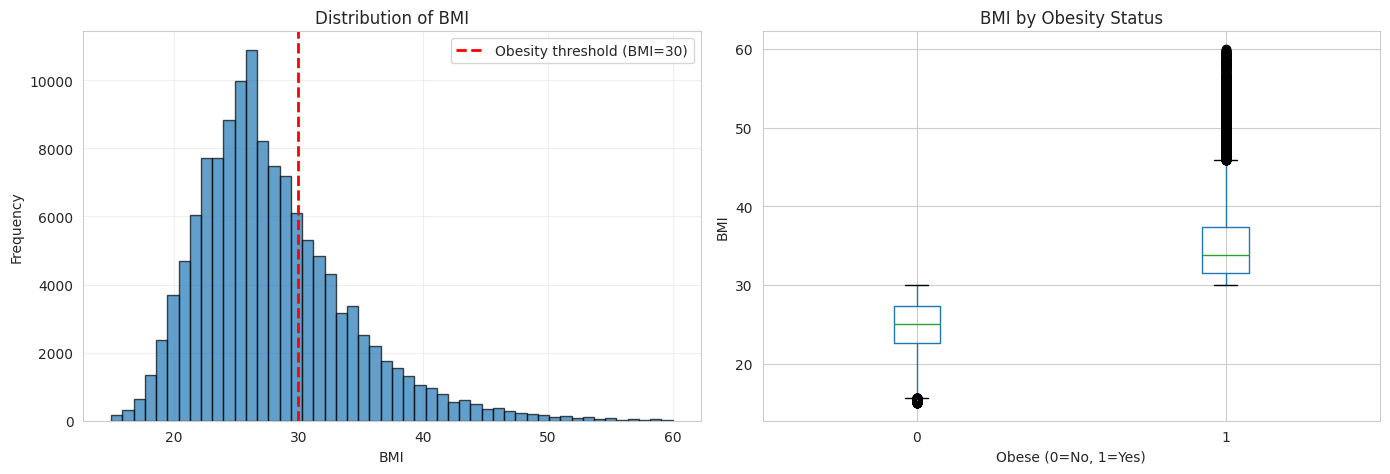

In [ ]:
# Visualize BMI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of BMI
axes[0].hist(df['BMI'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='Obesity threshold (BMI=30)')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of BMI')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by obesity status
df.boxplot(column='BMI', by='OBESE', ax=axes[1])
axes[1].set_xlabel('Obese (0=No, 1=Yes)')
axes[1].set_ylabel('BMI')
axes[1].set_title('BMI by Obesity Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/bmi_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("BMI distribution plot saved.")

In [ ]:
# Correlation heatmap of key variables
correlation_vars = ['OBESE', 'BMI', 'AGE', 'MALE', 'INCOME', 'EXERCISE',
                    'PHYSICAL_ACTIVITY_MIN', 'CURRENT_SMOKER', 'ALCOHOL_DAYS',
                    'FRUIT_PER_DAY', 'VEG_PER_DAY', 'FFRPTH14', 'GROCPTH14',
                    'PCT_LACCESS_POP15']

# Select only variables that exist in the dataframe
available_vars = [var for var in correlation_vars if var in df.columns]

# Calculate correlations
corr_matrix = df[available_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation heatmap saved.")

In [ ]:
# Summary statistics by obesity status
print("\n" + "="*80)
print("SUMMARY STATISTICS BY OBESITY STATUS")
print("="*80)

summary_vars = ['AGE', 'INCOME', 'EXERCISE', 'PHYSICAL_ACTIVITY_MIN',
                'CURRENT_SMOKER', 'FRUIT_PER_DAY', 'VEG_PER_DAY']

for var in summary_vars:
    if var in df.columns:
        print(f"\n{var}:")
        print(df.groupby('OBESE')[var].describe())